In [5]:
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import h5py
import pandas as pd
import deepdish as dd
import os
import numpy as np
import pylab as plt
from glob import glob
from tqdm import tqdm
import seaborn as sns
from scipy.stats import ncx2
from pesummary.gw.conversions.spins import spin_angles
import bilby
import sys
import pesummary
from pesummary.utils.samples_dict import SamplesDict
import sys
import random

## Parameters

In [27]:
"""
param_dict = {
    'mass_1': 30,
    'mass_2': 20,
    'luminosity_distance': 500,
    'theta_jn': np.pi/4,
    'ra': np.pi/3,
    'dec': np.pi/4,
    'psi': np.pi/3,
    'geocent_time': 0,
    'phase': 0,
    'a_1': 0.8,
    'a_2': 0.6,
    'tilt_1': np.pi/4,
    'tilt_2': np.pi/6,
    'phi_12': np.pi/4,
    'phi_jl': np.pi/2
}
"""
param_dict_ranges = {
    'total_mass': (10, 100),
    'mass_ratio': (0.1, 1),
    'luminosity_distance': (100, 1000),
    'theta_jn': (0, np.pi),
    'ra': (0, 2*np.pi),
    'dec': (0, np.pi),
    'psi': (0, 2*np.pi),
    'geocent_time': 0,
    'phase': 0,
    'a_1': (0, 0.99),
    'a_2': (0, 0.99),
    'tilt_1': 0,
    'tilt_2': 0,
    'phi_12': 0,
    'phi_jl': 0
    #'tilt_1': (0, np.pi),
    #'tilt_2': (0, np.pi),
    #'phi_12': (0, 2*np.pi),
    #'phi_jl': (0, 2*np.pi)
}
approx = 'IMRPhenomXPHM'
delta_f = 1./16,
f_low = 10
f_ref = f_low
f_high = 2048

In [28]:
n_samples = 50
param_dict = {}
for key, val in param_dict_ranges.items():
    if type(val) == tuple:
        start, end = val
        param_dict[key] = np.array([random.uniform(start, end) for i in range(n_samples)])
    else:
        param_dict[key] = np.ones(n_samples)*val

In [29]:
#samples = SamplesDict({key:[val] for key, val in param_dict.items()})
samples = SamplesDict(param_dict)
samples.generate_all_posterior_samples(delta_f = delta_f, f_start = f_low, f_low=f_low, f_ref=f_low, f_final=f_high)
samples

2025-09-16  13:38:09 PESummary WARNING : The redshift is being approximated using interpolation. Bear in mind that this does introduce a small error.
2025-09-16  13:38:10 PESummary INFO    : Averaging the final spin from the following fits: function bbh_final_spin_precessing_projected_UIB2016 at 0x73ba60ca7760, function bbh_final_spin_precessing_projected_Healyetal at 0x73ba60ca75b0, function bbh_final_spin_precessing_HBR2016 at 0x73ba60ca7910
2025-09-16  13:38:10 PESummary INFO    : Averaging the peak luminosity from the following fits: function bbh_peak_luminosity_non_precessing_UIB2016 at 0x73ba60ca79a0, function bbh_peak_luminosity_non_precessing_Healyetal at 0x73ba60ca7a30
2025-09-16  13:38:10 PESummary INFO    : Averaging the final mass from the following fits: function bbh_final_mass_non_precessing_UIB2016 at 0x73ba60ca6ef0, function bbh_final_mass_non_precessing_Healyetal at 0x73ba60ca5b40


{'total_mass': Array([46.66541675, 51.93927556, 53.87792606, 14.76148265, 96.32244447,
        17.77622051, 71.81924982, 46.80991694, 53.7137186 , 95.50060265,
        31.12441998, 41.35155164, 27.03812085, 91.80510913, 61.92742869,
        84.57397102, 38.99574565, 95.07573907, 11.96788968, 51.92439748,
        16.39775083, 43.42419323, 14.15840348, 96.29177339, 77.65835513,
        24.10101713, 61.76931017, 81.47552394, 67.97185721, 67.69769556,
        62.6895083 , 92.00980088, 34.36366143, 86.6468565 , 72.51328077,
        77.43225446, 11.94606721, 58.07333589, 42.58149334, 81.01191725,
        84.55394114, 31.35429837, 61.45488247, 73.63751675, 40.15615722,
        64.22796557, 43.31910658, 79.93549529, 23.54499789, 32.87171307]),
 'mass_ratio': Array([0.28463845, 0.43311403, 0.64267302, 0.68740342, 0.22308281,
        0.50530441, 0.7994052 , 0.68828799, 0.43584716, 0.92054176,
        0.56504549, 0.75930125, 0.48270851, 0.86236761, 0.39502227,
        0.58363138, 0.84964243, 0.54

In [30]:
samples[32:33]

{'total_mass': Array([34.36366143]),
 'mass_ratio': Array([0.47578332]),
 'luminosity_distance': Array([417.83225579]),
 'theta_jn': Array([0.71796598]),
 'ra': Array([3.17337023]),
 'dec': Array([1.66363317]),
 'psi': Array([1.21776109]),
 'geocent_time': Array([0.]),
 'phase': Array([0.]),
 'a_1': Array([0.46307366]),
 'a_2': Array([0.90036075]),
 'tilt_1': Array([0.]),
 'tilt_2': Array([0.]),
 'phi_12': Array([0.]),
 'phi_jl': Array([0.]),
 'redshift': Array([0.08857662]),
 'comoving_distance': Array([383.83174956]),
 'comoving_volume': Array([2.36870674e+08]),
 'inverted_mass_ratio': Array([2.10179709]),
 'chirp_mass': Array([13.79487731]),
 'mass_1': Array([23.2850317]),
 'mass_2': Array([11.07862972]),
 'symmetric_mass_ratio': Array([0.21845602]),
 'mass_1_source': Array([21.39034704]),
 'mass_2_source': Array([10.17717036]),
 'total_mass_source': Array([31.56751741]),
 'chirp_mass_source': Array([12.67239903]),
 'iota': Array([0.71796598]),
 'spin_1x': Array([0.]),
 'spin_1y': A

## PyCBC

In [31]:
from pycbc.waveform import get_fd_waveform
from pycbc.detector import Detector
from pycbc.filter.matchedfilter import sigmasq
import pycbc

In [32]:
PyCBC_wf_gen_keys_map = {
    'mass_1':'mass1', 
    'mass_2':'mass2', 
    'luminosity_distance':'distance',
    'iota':'inclination',
    'geocent_time':'trigger_time',
    'phase':'coa_phase',
    'ra':'ra',
    'dec':'dec',
    'psi':'polarization',
    'spin_1x':'spin1x',
    'spin_1y':'spin1y',
    'spin_1z':'spin1z',
    'spin_2x':'spin2x',
    'spin_2y':'spin2y',
    'spin_2z':'spin2z'
}

In [33]:
PyCBC_samples = {PyCBC_wf_gen_keys_map[key]:samples[key] for key in PyCBC_wf_gen_keys_map.keys()}
PyCBC_samples

{'mass1': Array([36.32572018, 36.24224909, 32.79893531,  8.74804594, 78.75382064,
        11.80905366, 39.91277208, 27.72626313, 37.40907809, 49.72586618,
        19.88723017, 23.50453148, 18.23562801, 49.29483764, 44.39171322,
        53.40508669, 21.08285638, 61.65112777,  6.7754966 , 43.73668608,
         9.27277527, 32.82437406, 10.02078866, 77.54271758, 52.63337293,
        13.38845408, 45.18255389, 71.95420994, 59.49515528, 38.7531864 ,
        39.42037803, 56.51428166, 23.2850317 , 47.77577714, 57.85474816,
        65.95253414, 10.75879285, 32.19317928, 27.3971786 , 58.61357531,
        61.29523973, 23.46261644, 49.72441049, 57.71837006, 21.43471117,
        44.36170017, 29.69060564, 40.71648   , 19.23825567, 21.73930465]),
 'mass2': Array([10.33969657, 15.69702646, 21.07899075,  6.01343672, 17.56862383,
         5.96716685, 31.90647774, 19.08365381, 16.30464051, 45.77473646,
        11.23718981, 17.84702016,  8.80249284, 42.51027148, 17.53571547,
        31.16888433, 17.9128892

In [34]:
def calc_PyCBC_snr(params_dict, f_low, f_high):
    hp, hc = get_fd_waveform(**params_dict)
    dets = ['L1', 'H1', 'I1']
    hf = {}
    snrs = {}
    snr_sq_netw = 0
    for det in dets:
        fp, fc = Detector(det).antenna_pattern(params_dict['ra'], params_dict['dec'], params_dict['polarization'], params_dict['trigger_time'])
        hf[det] = hp*fp + hc*fc
        psd = pycbc.psd.read.from_txt('../noise_curves/Asharp-asd.txt', len(hf[det]), hf[det].delta_f, f_low)
        snr_sq = sigmasq(hf[det], psd=psd, low_frequency_cutoff=f_low, high_frequency_cutoff=f_high)
        snrs[f'SNR_{det}'] = np.sqrt(snr_sq)
        snr_sq_netw += snr_sq
    snrs['SNR_network'] = np.sqrt(snr_sq_netw)
    return(hf, snrs)

In [35]:
#PyCBC_samples_wf_gen = {key: PyCBC_samples[key][0] for key in PyCBC_wf_gen_keys_map.values()}
PyCBC_samples_wf_gen = {key: PyCBC_samples[key] for key in PyCBC_wf_gen_keys_map.values()}
PyCBC_samples_wf_gen.update(approximant=approx, f_lower=f_low, delta_f=delta_f[0], f_ref=f_ref, f_final=f_high)
PyCBC_samples_wf_gen = pd.DataFrame(PyCBC_samples_wf_gen)
PyCBC_samples_wf_gen

,mass1,mass2,distance,inclination,trigger_time,coa_phase,ra,dec,polarization,spin1x,spin1y,spin1z,spin2x,spin2y,spin2z,approximant,f_lower,delta_f,f_ref,f_final
0,36.325720,10.339697,312.471883,0.294691,0.0,0.0,0.409453,1.394743,3.732171,0.0,0.0,0.720705,0.0,0.0,0.316600,IMRPhenomXPHM,10,0.0625,10,2048
1,36.242249,15.697026,397.364396,1.890244,0.0,0.0,0.658192,1.674538,4.224279,0.0,0.0,0.856852,0.0,0.0,0.878733,IMRPhenomXPHM,10,0.0625,10,2048
2,32.798935,21.078991,683.093008,1.233335,0.0,0.0,0.324989,2.647129,1.698011,0.0,0.0,0.117858,0.0,0.0,0.375767,IMRPhenomXPHM,10,0.0625,10,2048
3,8.748046,6.013437,809.380793,2.482622,0.0,0.0,3.512885,2.660889,1.991992,0.0,0.0,0.601178,0.0,0.0,0.580441,IMRPhenomXPHM,10,0.0625,10,2048
4,78.753821,17.568624,526.770142,2.223644,0.0,0.0,5.401769,2.272548,2.905709,0.0,0.0,0.075141,0.0,0.0,0.643828,IMRPhenomXPHM,10,0.0625,10,2048
5,11.809054,5.967167,492.047967,1.901361,0.0,0.0,1.213201,3.138423,0.107751,0.0,0.0,0.722534,0.0,0.0,0.792169,IMRPhenomXPHM,10,0.0625,10,2048
6,39.912772,31.906478,736.540452,0.664198,0.0,0.0,3.374313,0.626468,1.572453,0.0,0.0,0.370322,0.0,0.0,0.903331,IMRPhenomXPHM,10,0.0625,10,2048
7,27.726263,19.083654,972.961572,1.905436,0.0,0.0,3.253491,0.860259,3.818216,0.0,0.0,0.274665,0.0,0.0,0.986316,IMRPhenomXPHM,10,0.0625,10,2048
8,37.409078,16.304641,609.256061,0.010903,0.0,0.0,0.314874,0.471536,1.232634,0.0,0.0,0.936005,0.0,0.0,0.877183,IMRPhenomXPHM,10,0.0625,10,2048
9,49.725866,45.774736,857.909307,2.915123,0.0,0.0,2.369116,0.655270,2.088058,0.0,0.0,0.240564,0.0,0.0,0.272231,IMRPhenomXPHM,10,0.0625,10,2048


In [36]:
pycbc_hfs, pycbc_snrs = [], []
for sample in tqdm(PyCBC_samples_wf_gen.to_dict(orient='records')):
    hfs, snrs = calc_PyCBC_snr(sample, f_low=f_low, f_high=f_high)
    pycbc_hfs.append(hfs)
    pycbc_snrs.append(snrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.86it/s]


In [37]:
pycbc_snrs = pd.DataFrame(pycbc_snrs)
pycbc_snrs

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,206.861505,243.955020,111.992937,338.892538
1,57.130822,69.716914,47.405097,101.841162
2,56.170816,42.060262,68.050499,97.750174
3,44.626200,37.400131,32.118931,66.497317
4,31.973266,46.057909,98.007995,112.912301
5,27.726713,4.032703,19.973223,34.408762
6,98.953238,84.232693,177.226734,219.763976
7,16.066530,16.967465,42.829576,48.789351
8,225.927672,192.466930,160.662137,337.489488
9,59.606685,55.095453,171.080461,189.359421


## GWBench

In [38]:
from gwbench import Network, injections_CBC_params_redshift

In [39]:
fm_params_str = 'Mc eta DL iota tc phic ra dec psi'
def run_analysis(inj_params, logging_level='WARNING', num_cores=2):
    f"""
    Parameters:
    -------------------------------------------------------------
    inj_params: dict
        dict with keys: Mc, eta, tc, phic, 
                        DL, iota, ra, dec, psi, 
                        chi1x, chi1y, chi1z, chi2x, chi2y, chi2z
    Returns:
    -----------------------
    FM: matrix
        Fisher matrix with parameter order as: {fm_params_str}
    cov: matrix
        Covariance matrix corresponding to the FM
    errors: dict
        Parameter errors
    """
    wf_model_name = 'lal_bbh'
    wf_other_var_dic = {'approximant':approx, 'fRef':f_ref}
    user_psds = {'A-Sharp':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/Asharp-asd.txt', 
                            'is_asd': True},
                 'CE40':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE40-asd.txt', 
                         'is_asd': True}, 
                 'CE20':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/CE20-asd.txt', 
                         'is_asd': True}, 
                 'ET10-CoBA':{'psd_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/scripts/next_gen_detect/noise_curves/18213_ET10kmcolumns.txt', 
                              'is_asd': False}}
    user_locs = {'C1':{'longitude': -2.06175744538, 'latitude': 0.59637900541, 'arm_azimuth':0, 'which_arm':'y', 'shape':'L'}, 
                 'I1':{'longitude': 1.34444215058, 'latitude':0.34231676739, 'arm_azimuth':2.0527812170378947, #3.623591506466807, 
                       'which_arm':'x', 'shape':'L'}}
    conv_log = ('Mc', 'DL')
    ana_deriv_symbs_string = 'DL tc phic ra dec psi'
    network_spec = ['A-Sharp_L', 'A-Sharp_H', 'A-Sharp_I1']
    #network_spec = ['CE40_C1', 'CE20_CEB', 'ET10-CoBA_ET1', 'ET10-CoBA_ET2', 'ET10-CoBA_ET3']
    df = delta_f[0]
    f_arr = np.arange(f_low, f_high+df, df)
    net = Network(network_spec, logger_level=logging_level)
    net.set_net_vars(wf_model_name=wf_model_name, 
                     wf_other_var_dic=wf_other_var_dic,
                     f=f_arr, 
                     inj_params=inj_params,
                     deriv_symbs_string=fm_params_str,
                     ana_deriv_symbs_string=ana_deriv_symbs_string,
                     conv_log=conv_log, 
                     user_psds=user_psds,
                     user_locs=user_locs)
    net.calc_snrs()
    return(net)

In [40]:
gwbench_params_key = {
    'chirp_mass':'Mc',
    'symmetric_mass_ratio':'eta',
    'geocent_time':'tc',
    'phase':'phic',
    'luminosity_distance':'DL',
    'iota':'iota',
    'ra':'ra',
    'dec':'dec',
    'psi':'psi',
    'spin_1x':'chi1x',
    'spin_1y':'chi1y',
    'spin_1z':'chi1z',
    'spin_2x':'chi2x',
    'spin_2y':'chi2y',
    'spin_2z':'chi2z'
}

In [41]:
gwb_inj_params = {gwbench_params_key[key]:samples[key] for key in gwbench_params_key}
gwb_inj_params = pd.DataFrame(gwb_inj_params)
gwb_inj_params

,Mc,eta,tc,phic,DL,iota,ra,dec,psi,chi1x,chi1y,chi1z,chi2x,chi2y,chi2z
0,16.256767,0.172477,0.0,0.0,312.471883,0.294691,0.409453,1.394743,3.732171,0.0,0.0,0.720705,0.0,0.0,0.316600
1,20.413635,0.210883,0.0,0.0,397.364396,1.890244,0.658192,1.674538,4.224279,0.0,0.0,0.856852,0.0,0.0,0.878733
2,22.779467,0.238170,0.0,0.0,683.093008,1.233335,0.324989,2.647129,1.698011,0.0,0.0,0.117858,0.0,0.0,0.375767
3,6.292081,0.241420,0.0,0.0,809.380793,2.482622,3.512885,2.660889,1.991992,0.0,0.0,0.601178,0.0,0.0,0.580441
4,30.751063,0.149126,0.0,0.0,526.770142,2.223644,5.401769,2.272548,2.905709,0.0,0.0,0.075141,0.0,0.0,0.643828
5,7.224738,0.223000,0.0,0.0,492.047967,1.901361,1.213201,3.138423,0.107751,0.0,0.0,0.722534,0.0,0.0,0.792169
6,31.027464,0.246893,0.0,0.0,736.540452,0.664198,3.374313,0.626468,1.572453,0.0,0.0,0.370322,0.0,0.0,0.903331
7,19.955570,0.241478,0.0,0.0,972.961572,1.905436,3.253491,0.860259,3.818216,0.0,0.0,0.274665,0.0,0.0,0.986316
8,21.142478,0.211406,0.0,0.0,609.256061,0.010903,0.314874,0.471536,1.232634,0.0,0.0,0.936005,0.0,0.0,0.877183
9,41.526345,0.249572,0.0,0.0,857.909307,2.915123,2.369116,0.655270,2.088058,0.0,0.0,0.240564,0.0,0.0,0.272231


In [42]:
gwb_snrs = []
for sample in tqdm(gwb_inj_params.to_dict(orient='records')):
    net = run_analysis(sample)
    snrs = {det.det_key:det.snr for det in net.detectors}
    snrs.update({'SNR_network':net.snr})
    gwb_snrs.append(snrs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.23it/s]


In [43]:
gwb_snrs = pd.DataFrame(gwb_snrs).rename(columns={'A-Sharp_L':'SNR_L1', 
                                       'A-Sharp_H':'SNR_H1', 
                                       'A-Sharp_I1':'SNR_I1'})
gwb_snrs

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,207.068930,244.009687,111.765138,338.983355
1,57.655531,69.415798,47.901344,102.162870
2,56.133634,42.145399,67.773314,97.572751
3,44.643719,37.504511,32.153098,66.584320
4,32.677930,46.489207,97.658765,112.988176
5,27.938329,4.146809,20.111325,34.672924
6,98.528993,83.852498,177.436493,219.597161
7,15.864227,16.717391,43.101386,48.876112
8,225.989008,192.986110,160.778737,337.882336
9,60.078162,55.963283,170.374887,189.126615


In [44]:
pycbc_snrs

,SNR_L1,SNR_H1,SNR_I1,SNR_network
0,206.861505,243.955020,111.992937,338.892538
1,57.130822,69.716914,47.405097,101.841162
2,56.170816,42.060262,68.050499,97.750174
3,44.626200,37.400131,32.118931,66.497317
4,31.973266,46.057909,98.007995,112.912301
5,27.726713,4.032703,19.973223,34.408762
6,98.953238,84.232693,177.226734,219.763976
7,16.066530,16.967465,42.829576,48.789351
8,225.927672,192.466930,160.662137,337.489488
9,59.606685,55.095453,171.080461,189.359421


Text(0.5, 0, 'event count')

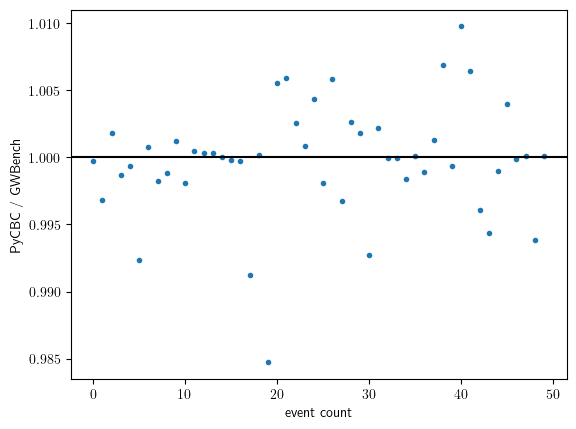

In [45]:
#plt.plot(pycbc_snrs['SNR_network'], pycbc_snrs['SNR_network']/gwb_snrs['SNR_network'], '.')
plt.plot(pycbc_snrs['SNR_network']/gwb_snrs['SNR_network'], '.')
plt.axhline(1, c='k')
plt.ylabel('PyCBC / GWBench')
#plt.xlabel('Network SNR')
plt.xlabel('event count')